In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import allensdk
import pickle
import pprint
from sklearn.decomposition import PCA

In [4]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info

In [5]:
boc = BrainObservatoryCache()

targeted_structures = boc.get_all_targeted_structures()
print("all targeted structures: " + str(targeted_structures))

stims = boc.get_all_stimuli()
print("all stimuli: \n")
pprint.pprint(stims)
cre_lines = boc.get_all_cre_lines()

all targeted structures: ['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']
all stimuli: 

['drifting_gratings',
 'locally_sparse_noise',
 'locally_sparse_noise_4deg',
 'locally_sparse_noise_8deg',
 'natural_movie_one',
 'natural_movie_three',
 'natural_movie_two',
 'natural_scenes',
 'spontaneous',
 'static_gratings']


## Data Selection

Deitch et al: 
analyzed all available excitatory Cre-lines, including all layers and brain areas.
Experiment containers group recordings from three different imaging sessions of the same field of view.
Each such container is considered an individual mouse.
Include only mice that passed a fixed criterion of at least 20 recorded cells in the compared time points.


Aitken:
solely concerned with respones to Natural Movie 1. \n
ONly from transgenic cre lines where excitatory neurons were targeted (Refer to table 1)
Omitted mouse data that had < 10 shared cells among the three sessions as well as data where two sessions were taken on the same day (3 mice). Total results in 73 mice.


<img src="data_structure.png" alt="drawing" width="800"/>

In [6]:
# Get experiment containers for excitatory cre-lines only

cre_lines = [ 
    'Emx1-IRES-Cre',
    'Fezf2-CreER',
    'Nr5a1-Cre',
    'Ntsr1-Cre_GN220',
    'Rbp4-Cre_KL100',
    'Rorb-IRES2-Cre',
    'Scnn1a-Tg3-Cre',
    'Slc17a7-IRES2-Cre',
    'Tlx3-Cre_PL56',
    ]

ecs = []
cre_lines_ecs = []

for cre_line in cre_lines:
    
    print("Cre Line:", cre_line)
    ecs_cre = boc.get_experiment_containers(cre_lines = [cre_line,], targeted_structures=['VISp'])
    print(" Experiment containers:", len(ecs_cre))
    ecs.extend(ecs_cre)
    cre_lines_ecs.extend([cre_line for _ in range(len(ecs_cre))])
    
print('\nTotal experiment containers:', len(ecs))

Cre Line: Emx1-IRES-Cre
 Experiment containers: 10
Cre Line: Fezf2-CreER
 Experiment containers: 4
Cre Line: Nr5a1-Cre
 Experiment containers: 8
Cre Line: Ntsr1-Cre_GN220
 Experiment containers: 6
Cre Line: Rbp4-Cre_KL100
 Experiment containers: 7
Cre Line: Rorb-IRES2-Cre
 Experiment containers: 8
Cre Line: Scnn1a-Tg3-Cre
 Experiment containers: 9
Cre Line: Slc17a7-IRES2-Cre
 Experiment containers: 60
Cre Line: Tlx3-Cre_PL56
 Experiment containers: 6

Total experiment containers: 118


In [7]:
def collect_experiments(ecs, stimulus = ['natural_movie_one'], min_exp_per_container = 3):
    '''
    Args: stimulus, ecs, min_exp_per_container
    Returns: exps
    '''
    
    n_containers = len(ecs) 

    exps = []
    cre_lines_experiments = []

    for container_idx in range(n_containers):
        ec_id = ecs[container_idx]['id']

        #Find experiments with natural movie one stimulus within our container
        exps_container = boc.get_ophys_experiments(experiment_container_ids=[ec_id], 
                                                   stimuli = stimulus, require_eye_tracking=True)
        # Require that the number of experiments associated with stimulus in a given container is only 3
        if len(exps_container) != min_exp_per_container:
            continue

        exps.extend(exps_container)
        cre_lines_experiments.extend([cre_lines_ecs[container_idx] for _ in range(3)])

    print('Total number of experiments:', len(exps))
    n_containers = int(len(exps)//3.0)

    print('Setting number of containers:', n_containers)
    
    return exps

In [8]:
def get_dff_vals_dataset(data_set, stimulus = 'natural_movie_one', n_frames = 900, n_repeats = 10, n_divs = 30):
    '''
    Args
    ------------
    data_set: BrainObservatoryNwbDataSet type obtained by using get_ophys_experiment_dataset.
    stimulus: (string) stimulus associated with data_set
    
    Returns
    ------------
    dff vals: a set of dff traces
    cell_ids: 
    '''
    
    if n_frames % n_divs > 0:
        raise ValueError('Frame number not divisible by division number')
    frames_per_repeat = int(n_frames/n_divs)
    
    time, dff_traces = data_set.get_dff_traces()
    cell_ids = data_set.get_cell_specimen_ids()
    stim_table = data_set.get_stimulus_table(stimulus)
    
    n_cells = len(cell_ids)

    frame_idxs = np.zeros((n_repeats, n_divs, int(n_frames/n_divs)))
    dff_vals = np.zeros((n_repeats, n_divs, n_cells))
    
    for repeat_idx in range(n_repeats):
        repeat_frames = np.array(stim_table.query('repeat == @repeat_idx')['start'])
        for div_idx in range(n_divs):
            div_repeat_idxs = repeat_frames[
                div_idx*frames_per_repeat:(div_idx+1)*frames_per_repeat
            ]
            
            frame_idxs[repeat_idx, div_idx] = div_repeat_idxs
            dff_vals[repeat_idx, div_idx] = np.mean(dff_traces[:, div_repeat_idxs], axis=1)
    return dff_vals, cell_ids


# function to plot running speed
def plot_running(ax):
    run_speed, run_times = dataset.get_running_speed()
    ax.plot(
        run_times,
        run_speed/run_speed.max(),
        '--',
        color = 'gray',
        linewidth = 1
    )
    

Testing out the rest of the code by loading a set of experiments

In [9]:
exps = collect_experiments(ecs)

Total number of experiments: 144
Setting number of containers: 48


In [10]:
# Getting experiments for a specific container
container_idx = 5
exp_idxs = []
for i in range(container_idx*3,(container_idx+1)*3):
    print(exps[i]['experiment_container_id'])
    exp_idxs.append(i)

616886391
616886391
616886391


In [71]:
exps5 = []
dff_vals_experiments= []
cell_ids_experiments = []

for i in exp_idxs:
    print(exps[i]['id'])
    exps5.append(exps[i])
    try:
        dataset = boc.get_ophys_experiment_data(exps[i]['id'])
        dff_, cell_id_ = get_dff_vals_dataset(dataset)
        dff_vals_experiments.append(dff_)
        cell_ids_experiments.append(cell_id_)
    except OSError as err:
        print("OS error: {}".format(err))
        dff_vals_experiments.append(np.nan)
        cell_ids_experiments.append(np.nan)
        
# pprint.pprint(exps5)
pprint.pprint(dff_vals_experiments)

636930038
623347352
617429820
[array([[[ 1.41864186e-02,  5.15603833e-02,  3.84196416e-02, ...,
          9.77279320e-02,  5.19129813e-01,  1.96691509e-02],
        [ 1.31812319e-03, -3.85858119e-04, -2.26538777e-02, ...,
         -4.06498127e-02, -4.49985154e-02,  5.22373011e-03],
        [ 8.23352078e-04, -2.43864459e-04, -1.65711250e-02, ...,
         -4.41244468e-02,  7.51669765e-01,  9.84275341e-03],
        ...,
        [ 1.81530472e-02, -4.28573117e-02,  6.19663275e-04, ...,
          1.56755060e-01, -7.25164777e-03, -8.15685000e-03],
        [ 2.81688683e-02,  4.11106020e-01,  2.50406973e-02, ...,
         -6.97083324e-02,  4.22855020e-02,  2.89534554e-02],
        [-1.98703296e-02,  1.13832198e-01, -2.90502850e-02, ...,
          2.03889191e-01, -7.54317828e-03, -7.97999091e-03]],

       [[ 8.90428724e-04, -2.95445751e-02,  1.31443348e-02, ...,
          2.60513812e-01,  1.63225189e-01,  1.78197492e-02],
        [-9.39438585e-03, -2.08718404e-02, -1.61781907e-02, ...,
       

In [18]:
dff_containers_all[0].shape

(10, 30, 54)

### Single Session Correlation Matrix

In [61]:
def alignment_angle(x, y):
    dot = np.dot(x,y)/(
         np.linalg.norm(x) * np.linalg.norm(y)
     )
    if dot > 1.0:
         dot = 1.0
    elif dot < -1.0:
        dot = -1.0
    
    return 180/np.pi * np.arccos(dot)

def correlation_single_session(dff_vals, cell_ids, n_divs = 30, n_repeats = 10):
    '''
    Args
    ------
    dataset: NWB dataset file for single experiment
    n_divs: number of stimulus divisions (default 30)
    n_repeats: number of repeats (default 10)
    
    Returns
    ------
    Tuple (session_corrs, sesion_angles)
    session_corrs: np.array of shape (n_repeats * n_divs, n_repeats * n_divs) of within session Pearson correlation coefficients.
    session_angles: np.array of shape (
    '''
    
    
    n_cells = cell_ids.shape
    
    shape = (n_repeats*n_divs, n_repeats*n_divs)
    session_corrs = np.zeros(shape)
    session_angles = np.zeros(shape)
    
    # Getting the correlation of repeat_i with repeat_j
    for repeat_i in range(n_repeats):
        for repeat_j in range(n_repeats):
            
            # Calculate the pearson coeff between dff repeats (for the entire movie)
            corr = np.corrcoef(dff_vals[repeat_i], dff_vals[repeat_j])[n_divs:, :n_divs] # gets the thirtieth 
            
            session_corrs[
                repeat_i * n_divs : (repeat_i + 1)*n_divs,
                repeat_j * n_divs : (repeat_j + 1)*n_divs] = corr
            
            for div_i in range(n_divs):
                for div_j in range(n_divs):
                    # for each second in the movie, calculate the alignment angle
                    angle = alignment_angle(dff_vals[repeat_i, div_i], dff_vals[repeat_j, div_j])
                    
                    session_angles[
                        repeat_i * n_divs + div_i,
                        repeat_j * n_divs + div_j] = angle
    
    return session_corrs, session_angles

[Text(0.5, 1.0, 'Correlation Matrix')]

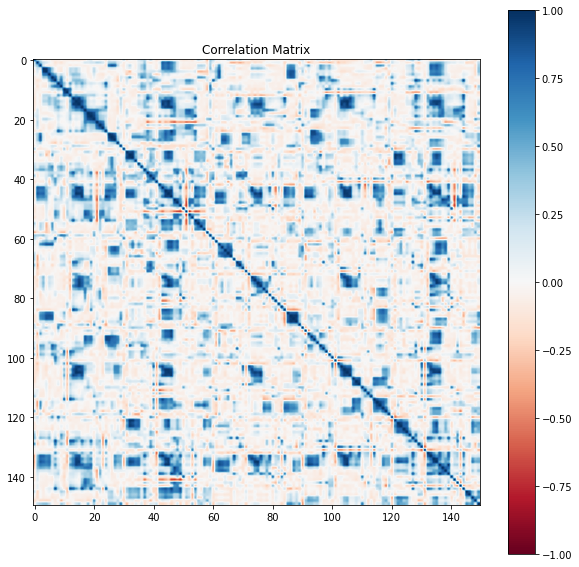

In [62]:
session_corrs, session_angles = correlation_single_session(dff_containers_all[0], cell_ids_all[0])

fig, ax = plt.subplots(1,1, figsize=(10,10))

c_plot = ax.imshow(session_corrs[:5*30, : 5*30], cmap = "RdBu", vmin = -1, vmax = 1)
c_bar = plt.colorbar(c_plot, ax = ax)

ax.set(title = 'Correlation Matrix')

[Text(0.5, 1.0, 'Angle Matrix')]

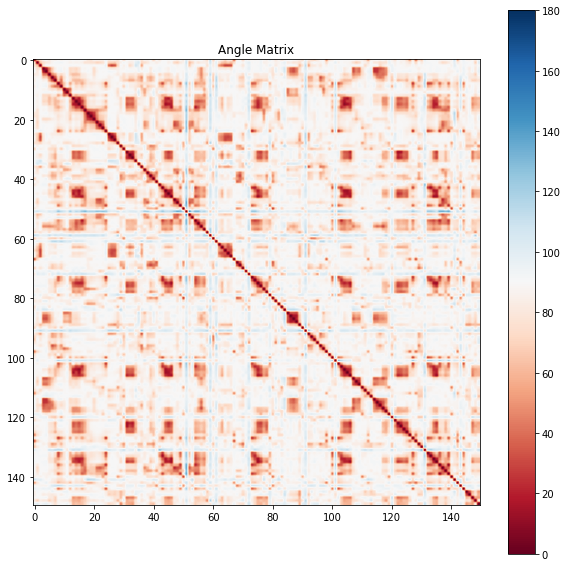

In [63]:

fig, ax = plt.subplots(1,1, figsize=(10,10))

c_plot = ax.imshow(session_angles[:5*30, : 5*30], cmap = "RdBu", vmin = 0, vmax = 180)
c_bar = plt.colorbar(c_plot, ax = ax)

ax.set(title = 'Angle Matrix')

### InterSession Correlation Matrix

In [102]:
def get_unique_cell_ids(cell_ids_experiment):
    """
    Finds all unique cell_ids. For each unique cell_id, creates a list of 
    corresponding indexes in datasets
    """
    unique_cell_ids = {}

    for cell_ids in cell_ids_experiment:
        for cell_idx, cell_id in enumerate(cell_ids):
            if cell_id not in unique_cell_ids.keys():
                unique_cell_ids[cell_id] = []

    # For each cell_id, finds the indexes in all experimental datasets
    # (lists index as nan if not in given dataset.
    for cell_id in unique_cell_ids.keys():
        for cell_ids in cell_ids_experiment:
            if cell_id in cell_ids:
                # unique_cell_ids[cell_id].append(cell_ids.index(cell_id))
                unique_cell_ids[cell_id].append(np.where(cell_ids == cell_id)[0][0])
            else:
                unique_cell_ids[cell_id].append(np.nan)

    return unique_cell_ids

def get_shared_cell_idxs(unique_cell_ids, verbose=True):
    """
    Finds all cell_ids shared across the datasets, and then returns a numpy 
    array which has the idx of said cell_ids in each dataset.
    """
    n_exp = len(unique_cell_ids[list(unique_cell_ids.keys())[0]])

    shared_cell_ids = []
    for cell_id in unique_cell_ids.keys():
        if np.sum(np.isnan(unique_cell_ids[cell_id])) == 0:
            shared_cell_ids.append(cell_id)

    if verbose:
        print('Shared IDs: {}/{}'.format(len(shared_cell_ids), 
                                        len(unique_cell_ids.keys())))

    # Map of shared cell_ids to cell_idxs in both datasets
    shared_cell_idxs = np.zeros((n_exp, len(shared_cell_ids)), dtype=np.int64)
    for cell_idx, cell_id in enumerate(shared_cell_ids):
        shared_cell_idxs[:, cell_idx] = unique_cell_ids[cell_id]

    return shared_cell_idxs


def correlation_across_sessions(cell_ids_experiments, dff_vals_experiments, n_sessions = 3, n_divs = 30):
    

#     exps_in_container = exps[container_idx * n_sessions : (container_idx + 1) * n_sessions]         
#     cell_ids_in_container = cell_ids_all[container_idx * n_sessions : (container_idx + 1) * n_sessions]
#     dff_vals_in_container = dff_vals_all[container_idx * n_sessions : (container_idx + 1) * n_sessions]

    unique_cell_ids = get_unique_cell_ids(cell_ids_experiments)
    shared_cell_idxs = get_shared_cell_idxs(unique_cell_ids)
    
    across_session_corrs = np.zeros((n_sessions*n_divs, n_sessions*n_divs))
    across_session_angles = np.zeros((n_sessions*n_divs, n_sessions*n_divs))
    
    avg_dff_vals = []
    
    # Collect avg dff for all sessions
    for session_idx in range(n_sessions):
        dff_vals_session = dff_vals_experiments[session_idx] 
        avg_dff_of_session = np.mean(dff_vals_session[:,:, shared_cell_idxs[session_idx]], axis = 0)
        avg_dff_vals.append(avg_dff_of_session)
    
    for session_i in range(n_sessions):
        for session_j in range(n_sessions):
            
            corr = np.corrcoef(avg_dff_vals[session_i], avg_dff_vals[session_j])[n_divs: , :n_divs]
            
            across_session_corrs[
                session_i * n_divs : (session_i + 1) * n_divs,
                session_j * n_divs : (session_j + 1) * n_divs ] = corr
            for div_i in range(n_divs):
                for div_j in range(n_divs):
                    across_session_angles[
                        session_i * n_divs + div_i,
                        session_j * n_divs + div_j] = alignment_angle(avg_dff_vals[session_i][div_i], avg_dff_vals[session_j][div_j]
                                      )
                        
    return across_session_corrs, across_session_angles

Now trying to test this out by first sorting our example container (container 5) experiments by age.

In [103]:
session_ages = [exp['acquisition_age_days'] for exp in exps5]
age_sort_idxs = np.argsort(session_ages)

sorted_exps = []
sorted_dff_vals = []
sorted_cell_ids = []
for session_idx in range(3):
    sorted_exps.append(exps5[age_sort_idxs[session_idx]])
    sorted_dff_vals.append(dff_vals_experiments[age_sort_idxs[session_idx]])
    sorted_cell_ids.append(cell_ids_experiments[age_sort_idxs[session_idx]])

In [106]:
across_session_corrs, across_session_angles = correlation_across_sessions(sorted_cell_ids, sorted_dff_vals)

Shared IDs: 32/77


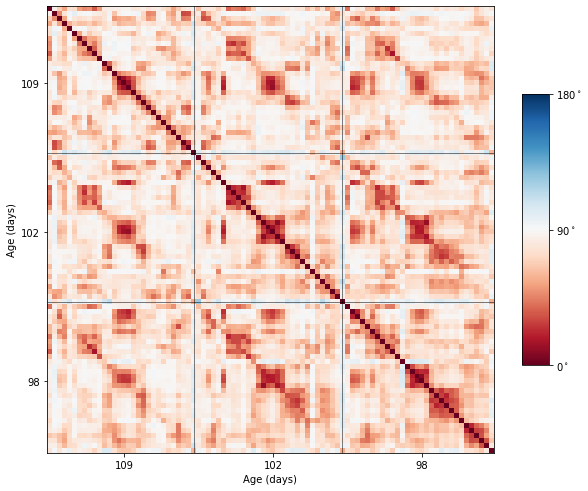

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# c_plot = ax.imshow(across_session_corrs, cmap='RdBu', vmin=-1, vmax=1)
c_plot = ax.imshow(across_session_angles, cmap='RdBu', vmin=0, vmax=180)
cbar = plt.colorbar(c_plot, ax=ax, shrink=0.5, ticks=[0, 90, 180], aspect=10)
cbar.ax.set_yticklabels(['0$^\circ$', '90$^\circ$', '180$^\circ$'])
n_divs = 30

tick_locs = [n_divs/2 + i*n_divs for i in range(n_sessions)]
ax.set_xticks(tick_locs)
ax.set_yticks(tick_locs)
tick_labels = [str(age) for age in session_ages]
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

ax.set_xlabel('Age (days)')
ax.set_ylabel('Age (days)')

for session_idx in range(1, n_sessions):
    ax.axhline((session_idx * n_divs)-1, color='k', linewidth=0.5)
    ax.axvline((session_idx * n_divs)-1, color='k', linewidth=0.5)


### PCA Decomposition

In [12]:
def drift_PCA(dff_vals_container, cell_ids_container):
    '''
    Args
    ------
    container_idx: int
    
    Returns
    ------
    dff_vals_pca1
    dff_vals_pca2
    '''
    
    def participation_ratio_vector(C):
        ''' participation ratio of a vector of variances '''
        return np.sum(C) ** 2 / np.sum(C*C)
    
    drift_pair_idxs = [[0,1],[1,2][0,2]]
    n_drifts = len(drift_pair_idxs)
    
#     cell_ids_container = cell_ids_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]
#     dff_vals_container = dff_vals_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]
    
    unique_cell_ids = get_unique_cell_ids(cell_ids_container)
    shared_cell_idxs = get_shared_cell_idxs(unique_cell_ids, verbose=False)
    n_shared = shared_cell_idxs[0].shape[0] 
    
    n_pcas = np.mean((n_repeats, n_shared))
    
    means_session = np.zeros((n_sessions, n_divs, n_shared))
    pcas_session = [[] for _ in range(n_sessions)]
    
    for session_idx in range(n_sessions):
        # find the dff vals of a given session for only their shared cells
        # then find the mean across the 10 repeats
        dff_vals_session = dff_vals_container[session_idx][:, :, shared_cell_idxs[session_idx]]
        print(dff_vals_session.shape)
        mean_session[session_idx] = np.mean(dff_vals_session, axis = 0)
        print(mean_session[session_idx].shape)
        
        for div_idx in range(n_divs):
            pca_div = PCA()
            pca_div.fit(dff_vals_session[:, div_idx])
            
            # Ensure all means (along PC directions) are positive
            pca_dir_signs = np.sign(np.mean(np.matmul(dff_vals_session[:, div_idx], pca_div.components_.T), axis=0))
            for pca_idx, pca_dir in enumerate(pca_div.components_):
                pca_div.components_[pca_idx, :] = pca_dir_signs[pca_idx] * pca_dir        
            pcas_session[session_idx].append(pca_div)
            
            # compute dim_var_space
            dim_var_space = participation_ratio_vector(
                pca_div.explained_variance_ratio_
            )
    
    drifts_session = np.zeros((n_drifts, n_divs, n_shared))
    pca_drift_magnitude = np.zeros((n_drifts, n_divs, n_pcas))
    
    for drift_idx in range(n_drifts):
        session_i = drift_pair_idxs[drift_idx][0]
        session_j = drift_pair_idxs[drift_idx][1]
        
        drifts_session[drift_idx] = (means_session[session_j] - means_session[session_i])
        
        for div_idx in range(n_divs):
            pca_drift = np.matmul(
                pcas_session[session_i][div_idx].components_,
                drifts_session[drift_idx, div_idx]
            )
        for pca_idx in range(n_pcas):
            pca_drift_magnitude[drift_idx, div_idx, pca_idx] = np.abs(pca_drift[pca_idx])
    
    pca_scale = 1.5

    for class_idx_idx, class_idx in enumerate(class_idxs):
        dff_vals_class = dff_vals_session[:, class_idx]
        class_pca = pcas_session[drift_pair[0]][class_idx]

        dff_vals_pca = np.matmul(dff_vals_class, class0_pca.components_.T)

        ax.scatter(dff_vals_pca[:, pc1], dff_vals_pca[:, pc2], marker='.', 
                   color=c_vals[1+class_idx_idx], alpha=0.5)

        class_mean = np.mean(dff_vals_pca, axis=0)

        ax.scatter(class_mean[pc1], class_mean[pc2],
                   marker='x', color=c_vals[1+class_idx_idx])

        pcas_proj =  np.matmul(class_pca.components_, class0_pca.components_.T)

        for pc_idx in (pc1, pc2):
            pcas_proj[pc_idx] = (pca_scale * class_pca.explained_variance_ratio_[pc_idx] *
                                 pcas_proj[pc_idx] / np.linalg.norm(pcas_proj[pc_idx]))
            print(class_pca.explained_variance_ratio_[pc_idx])
            print('Norm:', np.linalg.norm(pcas_proj[pc_idx]))
            ax.plot([class_mean[pc1], class_mean[pc1]+pcas_proj[pc_idx, pc1]],
                    [class_mean[pc2], class_mean[pc2]+pcas_proj[pc_idx, pc2]],
                    color=c_vals[1+class_idx_idx])
    
    ax.set_xlim([-1, 2])
    ax.set_ylim([-1, 2])
    ax.set_xticks([-1, 0, 1, 2])
    ax.set_yticks([-1, 0, 1, 2])
    ax.set_xticklabels([-1, 0, 1, 2])
    ax.set_yticklabels([-1, 0, 1, 2])
    ax.set_xlabel('PC1 (Group 1)')
    ax.set_ylabel('PC2 (Group 1)')

    jetplot.breathe(ax=ax)

    
    # Second figure, plot two sessions in the first sessions PC components
    fig, ax = plt.subplots(1, 1, figsize=(2,2))

    class_idx = class_idxs[0]
    colors = (c_vals[1], c_vals_l[1])
    for session_idx_idx, session_idx in enumerate(drift_pair):

        dff_vals_class = dff_vals_container[session_idx][:, class_idx, shared_cell_idxs[session_idx]]
        class_pca = pcas_session[session_idx][class_idx]

        dff_vals_pca = np.matmul(dff_vals_class, class0_pca.components_.T)

        ax.scatter(dff_vals_pca[:, pc1], dff_vals_pca[:, pc2], marker='.', 
                color=colors[session_idx_idx], alpha=0.5)

        class_mean = np.mean(dff_vals_pca, axis=0)

        ax.scatter(class_mean[pc1], class_mean[pc2],
                   marker='x', color=colors[session_idx_idx])

        pcas_proj =  np.matmul(class_pca.components_, class0_pca.components_.T)

        for pc_idx in (pc1, pc2):
            pcas_proj[pc_idx] = (pca_scale * class_pca.explained_variance_ratio_[pc_idx] *
                                 pcas_proj[pc_idx] / np.linalg.norm(pcas_proj[pc_idx]))
            print(class_pca.explained_variance_ratio_[pc_idx])
            print('Norm:', np.linalg.norm(pcas_proj[pc_idx]))
            ax.plot([class_mean[pc1], class_mean[pc1]+pcas_proj[pc_idx, pc1]],
                    [class_mean[pc2], class_mean[pc2]+pcas_proj[pc_idx, pc2]],
                    color=colors[session_idx_idx])


    ax.set_xlim([-1, 2])
    ax.set_ylim([-1, 2])
    ax.set_xticks([-1, 0, 1, 2])
    ax.set_yticks([-1, 0, 1, 2])
    ax.set_xticklabels([-1, 0, 1, 2])
    ax.set_yticklabels([-1, 0, 1, 2])
    ax.set_xlabel('PC1 (Group 1)')
    ax.set_ylabel('PC2 (Group 1)')


    jetplot.breathe(ax=ax)